# Finetuning for RAG



Here, we'll take you through the process, complete with code examples, to help you fine-tune your OpenAI model for usage with RAG like a pro.



To begin, we've selected a dataset where we've a guarantee that the retrieval is perfect. We've selected a subset of the [SQuAD](https://rajpurkar.github.io/SQuAD-explorer/) dataset, which is a collection of questions and answers about Wikipedia articles. We've also included samples where the answer is not present in the context, to demonstrate how RAG handles this case.

## Table of Contents
1. Setting up the Environment
2. Data Preparation
3. Running the Model
4. Evaluation
5. Fine-Tuning
6. Comparison

## Setting Up

### Install and Import Dependencies

In [1]:
# !pip install pandas openai tqdm tenacity pandarallel scikit-learn tiktoken

In [2]:
import json
import os
import time

import pandas as pd
import openai
from tenacity import retry, wait_exponential
from tqdm import tqdm
import numpy as np

tqdm.pandas()
openai.api_key = os.getenv("OPENAI_API_KEY")

## Loading the Data

Load your data and take a quick look at the first few rows. Notice that we've included a few samples where the answer is not present in the context.

In [3]:
df = pd.read_json("v2_1K_Seed=37_sample.json", lines=True)

In [4]:
df.head()

,title,question,context,is_impossible,answers
0,Southern_California,What is the United State's second-busiest comm...,Southern California is also home to the Port o...,True,[]
1,"Jacksonville,_Florida",Who did Jacksonville support with supplies dur...,"During the American Civil War, Jacksonville wa...",True,[]
2,Imperialism,colonial rule would not be considered what typ...,"Imperialism is defined as ""A policy of extendi...",True,[]
3,Intergovernmental_Panel_on_Climate_Change,Where are dissenting opinions published?,"Michael Oppenheimer, a long-time participant i...",True,[]
4,Southern_California,How many people does the Greater Los Angeles A...,Southern California includes the heavily built...,False,"[17.5 million, over 17.5 million, 17.5 million]"


## Using the OpenAI Model for Question Answering

### Prompt, API Call, and Answer
Create functions to get prompt messages and make API calls:

In [30]:
# Function to get prompt messages
def get_prompt(row):
    return [
        {"role": "system", "content": "You are a helpful assistant."},
        {
            "role": "user",
            "content": f"""Answer the following Question based on the Context only. Only answer from the Context. If you don't know the answer, say 'I don't know'.
    Question: {row.question}\n\n
    Context: {row.context}\n\n
    Answer:\n""",
        },
    ]


# Function with tenacity for retries
@retry(wait=wait_exponential(multiplier=1, min=2, max=6))
def api_call(messages, model):
    return openai.ChatCompletion.create(
        model=model,
        messages=messages,
        stop=["\n\n"],
        max_tokens=100,
        temperature=0.0,
    )


# Main function to answer question
def answer_question(row, model="gpt-3.5-turbo-0613"):
    messages = get_prompt(row)
    response = api_call(messages, model)
    return response["choices"][0]["message"]["content"]

### Running the model

In [ ]:
# Use progress_apply with tqdm for progress bar
df["generated_answer"] = df.progress_apply(answer_question, axis=1)

In [8]:
# Optionally, save the results to a JSON file
# df.to_json("1K_with_generated_answers.json", lines=True, orient="records") # Save to JSON

## Evaluation

To evaluate the model's performance, compare the predicted answer to the actual answers -- if any of the actual answers are present in the predicted answer, then it's a match. We've also created error categories to help you understand where the model is struggling.

1. Expected and Right: The model responsded the correct answer. It may have also included other answers that were not in the context.
2. Expected but "IDK": The model responded with "I don't know" (IDK) while the answer was present in the context. *This is a model error* and better than giving the wrong answer. We exclude this from the overall error rate.
3. Expected but Wrong: The model responded with an incorrect answer. *This is a model ERROR.*
4. Hallucination: The model responded with an answer, when "I don't know" was expected. **This is a model error.** 
5. Did not expect and IDK: The model responded with "I don't know" (IDK) and the answer was not present in the context. *This is a model WIN.*

In [5]:
class ConfusionMatrixEvaluator:
    def __init__(self, df, answers_column="generated_answer"):
        self.df = df
        self.y_pred = []
        self.labels = [
            "Expected and Right",
            "Expected but IDK",
            "Expected but Wrong",
            "Hallucination",
            "Did not Expect and IDK",
        ]
        self.answers_column = answers_column

    def _evaluate_single_row(self, row):
        is_impossible = row["is_impossible"]
        generated_answer = row[self.answers_column].lower()
        actual_answers = [ans.lower() for ans in row["answers"]]

        y_pred = (
            "Expected and Right"
            if not is_impossible
            and any(ans in generated_answer for ans in actual_answers)
            else "Expected but IDK"
            if not is_impossible and generated_answer == "i don't know"
            else "Expected but Wrong"
            if not is_impossible and generated_answer not in actual_answers
            else "Hallucination"
            if is_impossible and generated_answer != "i don't know"
            else "Did not Expect and IDK"
        )
        return y_pred

    def evaluate_answers(self):
        self.y_pred = self.df.apply(self._evaluate_single_row, axis=1)

    def generate_matrices(self, use_percentages=False):
        # Using value_counts to create a Series of frequencies, then reindexing to include missing labels with count 0
        freq_series = self.y_pred.value_counts().reindex(self.labels, fill_value=0)
        if use_percentages:
            total = freq_series.sum()
            freq_series = (freq_series / total * 100).apply("{0:.2f}%".format)
        return freq_series


evaluator = ConfusionMatrixEvaluator(df, answers_column="generated_answer")
evaluator.evaluate_answers()
error_categories = evaluator.generate_matrices(use_percentages=True)
error_categories

## Fine-Tuning

### Prepare the Fine-Tuning Data

In [31]:
def dataframe_to_jsonl(df):
    def create_jsonl_entry(row):
        answer = row["answers"][0] if row["answers"] else "I don't know"
        messages = [
            {"role": "system", "content": "You are a helpful assistant."},
            {
                "role": "user",
                "content": f"""Answer the following Question based on the Context only. Only answer from the Context. If you don't know the answer, say 'I don't know'.
            Question: {row.question}\n\n
            Context: {row.context}\n\n
            Answer:\n""",
            },
            {"role": "assistant", "content": answer},
        ]
        return json.dumps({"messages": messages})

    jsonl_output = df.progress_apply(create_jsonl_entry, axis=1)
    return "\n".join(jsonl_output)


with open("squad-stratified-1000-ft-v2.json", "w") as f:
    f.write(dataframe_to_jsonl(df))

100%|██████████| 1000/1000 [00:00<00:00, 59898.09it/s]


### [Optional] Verify the Fine-Tuning Data

The script below will verify that the data is in the format that OpenAI expects.

In [12]:
# # We start by importing the required packages

# import json
# import os

# # Next, we specify the data path and open the JSONL file

# data_path = "squad-stratified-100-ft-v1.json"

# # Load dataset
# with open(data_path) as f:
#     dataset = [json.loads(line) for line in f]

# # We can inspect the data quickly by checking the number of examples and the first item

# # Initial dataset stats
# print("Num examples:", len(dataset))
# print("First example:")
# for message in dataset[0]["messages"]:
#     print(message)

# # Now that we have a sense of the data, we need to go through all the different examples and check to make sure the formatting is correct and matches the Chat completions message structure

# # Format error checks
# format_errors = defaultdict(int)

# for ex in dataset:
#     if not isinstance(ex, dict):
#         format_errors["data_type"] += 1
#         continue

#     messages = ex.get("messages", None)
#     if not messages:
#         format_errors["missing_messages_list"] += 1
#         continue

#     for message in messages:
#         if "role" not in message or "content" not in message:
#             format_errors["message_missing_key"] += 1

#         if any(k not in ("role", "content", "name") for k in message):
#             format_errors["message_unrecognized_key"] += 1

#         if message.get("role", None) not in ("system", "user", "assistant"):
#             format_errors["unrecognized_role"] += 1

#         content = message.get("content", None)
#         if not content or not isinstance(content, str):
#             format_errors["missing_content"] += 1

#     if not any(message.get("role", None) == "assistant" for message in messages):
#         format_errors["example_missing_assistant_message"] += 1

# if format_errors:
#     print("Found errors:")
#     for k, v in format_errors.items():
#         print(f"{k}: {v}")
# else:
#     print("No errors found")

# # Beyond the structure of the message, we also need to ensure that the length does not exceed the 4096 token limit.

# # Token counting functions
# encoding = tiktoken.get_encoding("cl100k_base")

# # not exact!
# # simplified from https://github.com/openai/openai-cookbook/blob/main/examples/How_to_count_tokens_with_tiktoken.ipynb
# def num_tokens_from_messages(messages, tokens_per_message=3, tokens_per_name=1):
#     num_tokens = 0
#     for message in messages:
#         num_tokens += tokens_per_message
#         for key, value in message.items():
#             num_tokens += len(encoding.encode(value))
#             if key == "name":
#                 num_tokens += tokens_per_name
#     num_tokens += 3
#     return num_tokens

# def num_assistant_tokens_from_messages(messages):
#     num_tokens = 0
#     for message in messages:
#         if message["role"] == "assistant":
#             num_tokens += len(encoding.encode(message["content"]))
#     return num_tokens

# def print_distribution(values, name):
#     print(f"\n#### Distribution of {name}:")
#     print(f"min / max: {min(values)}, {max(values)}")
#     print(f"mean / median: {np.mean(values)}, {np.median(values)}")
#     print(f"p5 / p95: {np.quantile(values, 0.1)}, {np.quantile(values, 0.9)}")

# # Last, we can look at the results of the different formatting operations before proceeding with creating a fine-tuning job:

# # Warnings and tokens counts
# n_missing_system = 0
# n_missing_user = 0
# n_messages = []
# convo_lens = []
# assistant_message_lens = []

# for ex in dataset:
#     messages = ex["messages"]
#     if not any(message["role"] == "system" for message in messages):
#         n_missing_system += 1
#     if not any(message["role"] == "user" for message in messages):
#         n_missing_user += 1
#     n_messages.append(len(messages))
#     convo_lens.append(num_tokens_from_messages(messages))
#     assistant_message_lens.append(num_assistant_tokens_from_messages(messages))

# print("Num examples missing system message:", n_missing_system)
# print("Num examples missing user message:", n_missing_user)
# print_distribution(n_messages, "num_messages_per_example")
# print_distribution(convo_lens, "num_total_tokens_per_example")
# print_distribution(assistant_message_lens, "num_assistant_tokens_per_example")
# n_too_long = sum(l > 4096 for l in convo_lens)
# print(f"\n{n_too_long} examples may be over the 4096 token limit, they will be truncated during fine-tuning")

# # Pricing and default n_epochs estimate
# MAX_TOKENS_PER_EXAMPLE = 4096

# MIN_TARGET_EXAMPLES = 100
# MAX_TARGET_EXAMPLES = 25000
# TARGET_EPOCHS = 3
# MIN_EPOCHS = 1
# MAX_EPOCHS = 25

# n_epochs = TARGET_EPOCHS
# n_train_examples = len(dataset)
# if n_train_examples * TARGET_EPOCHS < MIN_TARGET_EXAMPLES:
#     n_epochs = min(MAX_EPOCHS, MIN_TARGET_EXAMPLES // n_train_examples)
# elif n_train_examples * TARGET_EPOCHS > MAX_TARGET_EXAMPLES:
#     n_epochs = max(MIN_EPOCHS, MAX_TARGET_EXAMPLES // n_train_examples)

# n_billing_tokens_in_dataset = sum(min(MAX_TOKENS_PER_EXAMPLE, length) for length in convo_lens)
# print(f"Dataset has ~{n_billing_tokens_in_dataset} tokens that will be charged for during training")
# print(f"By default, you'll train for {n_epochs} epochs on this dataset")
# print(f"By default, you'll be charged for ~{n_epochs * n_billing_tokens_in_dataset} tokens")
# print("See pricing page to estimate total costs")

### Push the Fine-Tuning data to OpenAI

In [16]:
file_object = openai.File.create(
    file=open("squad-stratified-100-ft-v1.json", "r"),
    purpose="fine-tune",
)

while file_object["status"] != "processed":
    file_object = openai.File.retrieve(file_object["id"])
    time.sleep(5)

<File file id=file-TjkDD0C39b4S1JZstMly98pv at 0x106297bd0> JSON: {
  "object": "file",
  "id": "file-TjkDD0C39b4S1JZstMly98pv",
  "purpose": "fine-tune",
  "filename": "file",
  "bytes": 131291,
  "created_at": 1693836561,
  "status": "uploaded",
  "status_details": null
}

### Create Fine Tuning Job

In [19]:
ft_job = openai.FineTuningJob.create(
    training_file=file_object["id"], model="gpt-3.5-turbo", suffix="v1"
)
while openai.FineTuningJob.retrieve(ft_job["id"]).fine_tuned_model is None:
    time.sleep(10)

In [26]:
model_id = openai.FineTuningJob.retrieve(ft_job["id"]).fine_tuned_model

### Try out the Fine-Tuned Model

In [29]:
completion = openai.ChatCompletion.create(
    model=model_id,
    messages=[
        {"role": "system", "content": "You are a helpful assistant."},
        {"role": "user", "content": "Hello!"},
        {"role": "assistant", "content": "Hi, how can I help you today?"},
        {
            "role": "user",
            "content": "Can you answer the following question based on the given context? If not, say, I don't know:\n\nQuestion: What is the capital of France?\n\nContext: The capital of Mars is Gaia. Answer:",
        },
    ],
)

print(completion.choices[0].message)

{
  "role": "assistant",
  "content": "I don't know"
}


## Comparison

### Get Answers from the Fine-Tuned Model

In [32]:
df["ft_generated_answer"] = df.progress_apply(answer_question, model=model_id, axis=1)

100%|██████████| 1000/1000 [12:14<00:00,  1.36it/s] 


In [38]:
# Initialize the evaluator
finetuned_model_evaluator = ConfusionMatrixEvaluator(
    df, answers_column="ft_generated_answer"
)

# Run the evaluation
finetuned_model_evaluator.evaluate_answers()
finetuned_model_error_categories = finetuned_model_evaluator.generate_matrices(
    use_percentages=True
)
finetuned_model_error_categories

Expected and Right        30.10%
Expected but IDK          15.20%
Expected but Wrong         5.00%
Hallucination              7.10%
Did not Expect and IDK    42.60%
Name: count, dtype: object

In [2]:
# Optionally, save the results to a JSON file
# df.to_json("1K_with_ft_generated_answers.json", lines=True, orient="records")

### Plotting the Results

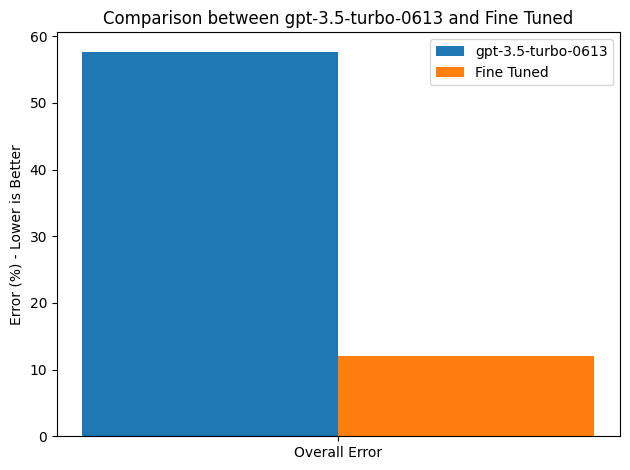

In [8]:
# Importing required libraries for plotting
import matplotlib.pyplot as plt
import numpy as np


def evaluate_matrix(df, answers_column):
    """
    Evaluate the confusion matrix for a given DataFrame and answer column.
    """
    evaluator = ConfusionMatrixEvaluator(df, answers_column=answers_column)
    evaluator.evaluate_answers()
    matrix = evaluator.generate_matrices(use_percentages=True)
    return matrix


def plot_overall_error(matrix1, matrix2, label1, label2):
    """
    Plot a bar chart showing only the overall error between two confusion matrices.
    """
    # Calculate overall error
    error_categories = ["Expected but Wrong", "Hallucination"]
    matrix1_error = sum(
        [float(matrix1.loc[cat].replace("%", "")) for cat in error_categories]
    )
    matrix2_error = sum(
        [float(matrix2.loc[cat].replace("%", "")) for cat in error_categories]
    )

    labels = ["Overall Error"]
    matrix1_values = [matrix1_error]
    matrix2_values = [matrix2_error]

    x = np.arange(len(labels))
    width = 0.35

    fig, ax = plt.subplots()
    ax.bar(x - width / 2, matrix1_values, width, label=label1)
    ax.bar(x + width / 2, matrix2_values, width, label=label2)

    ax.set_ylabel("Error (%) - Lower is Better")
    ax.set_title("Comparison between {} and {}".format(label1, label2))
    ax.set_xticks(x)
    ax.set_xticklabels(labels)
    ax.legend()

    fig.tight_layout()
    plt.show()


matrix_plain = evaluate_matrix(df, "generated_answer")
matrix_ft = evaluate_matrix(df, "ft_generated_answer")
# Plot only the overall error
plot_overall_error(matrix_plain, matrix_ft, "gpt-3.5-turbo-0613", "Fine Tuned")

# Few Shot Learning with Qdrant to Improve RAG

So far, we've been using the OpenAI model to answer questions where the answer is present in the context. But what if we want to answer questions where the answer is not present in the context? This is where few-shot learning comes in. Few-shot learning is a type of transfer learning that allows us to answer questions where the answer is not present in the context. We can do this by providing a few examples of the answer we're looking for, and the model will learn to answer questions where the answer is not present in the context.

## Few Shot Prompting

We'll select a few examples from the dataset, including cases where the answer is not present in the context. We'll then use these examples to create a prompt that we can use to fine-tune the model.

We'll measure the baseline on our previous 1K dataset, and then we'll fine-tune the model on the new dataset. We'll then measure the performance of the fine-tuned model on the same 1K dataset.

### Get the Training Data

In [1]:
# !wget https://rajpurkar.github.io/SQuAD-explorer/dataset/train-v2.0.json -O train.json

In [2]:
import pandas as pd
import json


def json_to_dataframe_with_titles(json_data):
    qas = []
    context = []
    is_impossible = []
    answers = []
    titles = []

    for article in json_data["data"]:
        title = article["title"]
        for paragraph in article["paragraphs"]:
            for qa in paragraph["qas"]:
                qas.append(qa["question"].strip())
                context.append(paragraph["context"])
                is_impossible.append(qa["is_impossible"])

                ans_list = []
                for ans in qa["answers"]:
                    ans_list.append(ans["text"])
                answers.append(ans_list)
                titles.append(title)

    df = pd.DataFrame(
        {
            "title": titles,
            "question": qas,
            "context": context,
            "is_impossible": is_impossible,
            "answers": answers,
        }
    )
    return df


train_df = json_to_dataframe_with_titles(json.load(open("train.json", "r")))
train_df.head()

,title,question,context,is_impossible,answers
0,Beyoncé,When did Beyonce start becoming popular?,Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ b...,False,[in the late 1990s]
1,Beyoncé,What areas did Beyonce compete in when she was...,Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ b...,False,[singing and dancing]
2,Beyoncé,When did Beyonce leave Destiny's Child and bec...,Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ b...,False,[2003]
3,Beyoncé,In what city and state did Beyonce grow up?,Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ b...,False,"[Houston, Texas]"
4,Beyoncé,In which decade did Beyonce become famous?,Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ b...,False,[late 1990s]


### Embed the Training Data

In [21]:
import os
from qdrant_client import QdrantClient
from qdrant_client.http import models
from qdrant_client.http.models import PointStruct
from qdrant_client.http.models import Distance, VectorParams

In [6]:
qdrant_client = QdrantClient(
    url=os.getenv("QDRANT_URL"), api_key=os.getenv("QDRANT_API_KEY")
)

collection_name = "cookbook"  # An arbitrary name for the collection


# Create the collection
qdrant_client.recreate_collection(
    collection_name=collection_name,
    vectors_config=VectorParams(size=384, distance=Distance.COSINE),
)

True

In [17]:
# !pip install fastembed

In [19]:
from fastembed.embedding import DefaultEmbedding
from typing import List
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm

tqdm.pandas()

embedding_model = DefaultEmbedding()

In [14]:
def generate_points_from_dataframe(df: pd.DataFrame) -> List[PointStruct]:
    questions = df["question"].tolist()
    pbar = tqdm(total=len(questions), desc="Generating embeddings")

    # Generate embeddings for each question and update tqdm progress bar
    embeddings = []
    for question in questions:
        embedding = list(embedding_model.embed([question]))[0]
        embeddings.append(embedding)
        pbar.update(1)
    pbar.close()

    # Convert embeddings to list of lists
    embeddings_list = [embedding.tolist() for embedding in embeddings]

    # Create a temporary DataFrame to hold the embeddings and existing DataFrame columns
    temp_df = df.copy()
    temp_df["embeddings"] = embeddings_list
    temp_df["id"] = temp_df.index

    # Generate PointStruct objects using DataFrame apply method
    points = temp_df.progress_apply(
        lambda row: PointStruct(
            id=row["id"],
            vector=row["embeddings"],
            payload={
                "question": row["question"],
                "title": row["title"],
                "context": row["context"],
                "is_impossible": row["is_impossible"],
                "answers": row["answers"],
            },
        ),
        axis=1,
    ).tolist()

    return points


small_df = train_df.sample(1000, random_state=37)
points = generate_points_from_dataframe(small_df)

Generating embeddings:   0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

In [15]:
operation_info = qdrant_client.upsert(
    collection_name=collection_name, wait=True, points=points
)
print(operation_info)

operation_id=0 status=<UpdateStatus.COMPLETED: 'completed'>


In [17]:
df = pd.read_json("1K_with_ft_generated_answers.json", lines=True, orient="records")

In [71]:
def get_few_shot_prompt(row):

    query, row_context = row["question"], row["context"]

    embeddings = list(embedding_model.embed([query]))
    query_embedding = embeddings[0].tolist()

    num_of_qa_to_retrieve = 6

    # Pick the most similar question from the collection
    q1 = qdrant_client.search(
        collection_name=collection_name,
        query_vector=query_embedding,
        with_payload=True,
        limit=num_of_qa_to_retrieve,
        query_filter=models.Filter(
            must=[
                models.FieldCondition(
                    key="is_impossible",
                    match=models.MatchValue(
                        value=False,
                    ),
                ),
            ],
        )
    )

    # Pick the next best question which has same title but impossible answer/I don't know answer
    q2 = qdrant_client.search(
        collection_name=collection_name,
        query_vector=query_embedding,
        query_filter=models.Filter(
            must=[
                models.FieldCondition(
                    key="is_impossible",
                    match=models.MatchValue(
                        value=True,
                    ),
                ),
            ]
        ),
        with_payload=True,
        limit=num_of_qa_to_retrieve,
    )


    instruction = """Answer the following Question based on the Context only. Only answer from the Context. If you don't know the answer, say 'I don't know'.\n\n"""
    # If there is a next best question, add it to the prompt
    
    def q_to_prompt(q):
        question, context = q.payload["question"], q.payload["context"]
        answer = q.payload["answers"][0] if len(q.payload["answers"]) > 0 else "I don't know"
        return [
            {
                "role": "user", 
                "content": f"""Question: {question}\n\nContext: {context}\n\nAnswer:"""
            },
            {"role": "assistant", "content": answer},
        ]

    rag_prompt = []
    if len(q1) >= 1:
        rag_prompt += q_to_prompt(q1[0])
    # If the next best question is not the same as the question, add it to the prompt
    if len(q2) >= 1 and (q2[0].payload["question"] != q1[0].payload["question"]):
        rag_prompt += q_to_prompt(q2[0])

    rag_prompt += [
        {
            "role": "user",
            "content": f"""Question: {query}\n\nContext: {row_context}\n\nAnswer:"""
        },
    ]

    rag_prompt = [{"role": "system", "content": instruction}] + rag_prompt
    return rag_prompt

df["few_shot_prompt_1K"] = df.progress_apply(get_few_shot_prompt, axis=1)

  0%|          | 0/1000 [00:00<?, ?it/s]



## Finetuning and Inference Changes
We will use the same dataset as before, but this time we will only provide a few examples of the answer we're looking for. We will also provide a few examples of the answer we're not looking for. This will allow the model to learn to handle questions where the answer is not present in the context. 

We assumed perfect retrieval in the previous section, but we will not assume perfect retrieval here. Instead, we will use a vector search engine to find similar questions and answers, and then use those to finetuning the model. We will use [Qdrant](https://qdrant.tech/), an open-source vector search engine. We will use Qdrant to find similar questions and answers, and then use those to finetuning the model.